In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, LSTM, GRU, CuDNNLSTM, CuDNNGRU, Masking, TimeDistributed, BatchNormalization
from keras.layers import Concatenate, Reshape, Bidirectional, Softmax, LocallyConnected1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import math

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import isolearn_keras as iso

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

from scipy.stats import pearsonr

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load pair enrichment data

pair_df = pd.read_csv('pair_df_all_experiments_w_extra_fields.csv', sep='\t')

print('len(pair_df) = ' + str(len(pair_df)))


len(pair_df) = 47524


In [3]:
measured_df_a = pair_df[['monomer_id_1', 'amino_seq_1']].drop_duplicates(subset='amino_seq_1', keep='first').copy().reset_index(drop=True)
measured_df_a = measured_df_a.rename(
    columns = {
        'monomer_id_1' : 'protein_id',
        'amino_seq_1' : 'protein_seq'
    }
)

measured_df_b = pair_df[['monomer_id_2', 'amino_seq_2']].drop_duplicates(subset='amino_seq_2', keep='first').copy().reset_index(drop=True)
measured_df_b = measured_df_b.rename(
    columns = {
        'monomer_id_2' : 'protein_id',
        'amino_seq_2' : 'protein_seq'
    }
)

measured_df = pd.concat([measured_df_a, measured_df_b]).drop_duplicates(subset='protein_seq', keep='first').copy().reset_index(drop=True)


In [4]:

candidate_dict = {}
with open('180312_massive_set.fasta') as f :
    i = 0
    protein_id = ''
    protein_str = ''
    for line in f :
        line_strip = line.strip()
        if line_strip[0] == '>' :
            if i > 0 :
                candidate_dict[protein_id] = protein_str
            protein_id = line_strip[1:]
            protein_str = ''
        else :
            protein_str += line_strip
        
        i += 1

candidate_dict[protein_id] = protein_str

protein_ids = []
protein_seqs = []
for protein_id in candidate_dict :
    protein_ids.append(protein_id)
    protein_seqs.append(candidate_dict[protein_id])

candidate_df = pd.DataFrame({
    'protein_id' : protein_ids,
    'protein_seq' : protein_seqs
})

candidate_df = candidate_df[['protein_id', 'protein_seq']]
candidate_df = candidate_df.copy().reset_index(drop=True)

candidate_df['orientation'] = candidate_df['protein_id'].apply(lambda x: x[-1])

candidate_df_a = candidate_df.query("orientation == 'A'").copy().reset_index(drop=True)
candidate_df_b = candidate_df.query("orientation == 'B'").copy().reset_index(drop=True)

candidate_df_a['protein_id_cognate'] = candidate_df_a['protein_id'].apply(lambda x: x[:-1] + "B")

pair_df = candidate_df_a.join(candidate_df_b.set_index('protein_id'), on='protein_id_cognate', how='inner', rsuffix='_cognate').copy().reset_index(drop=True)

pair_df = pair_df.rename(
    columns = {
        'protein_id' : 'monomer_id_1',
        'protein_seq' : 'amino_seq_1',
        'orientation' : 'orientation_1',
        'protein_id_cognate' : 'monomer_id_2',
        'protein_seq_cognate' : 'amino_seq_2',
        'orientation_cognate' : 'orientation_2'
    }
)

pair_df['interacts'] = 1.


In [5]:
#Remove held-out experimentally assayed pairs

print("len(pair_df) = " + str(len(pair_df)))

remove_ix_list = pair_df.join(measured_df.set_index('protein_seq'), on='amino_seq_2', how='inner')['monomer_id_1'].unique().tolist()

pair_df = pair_df.loc[~pair_df['monomer_id_1'].isin(remove_ix_list)].copy().reset_index(drop=True)

print("len(pair_df) = " + str(len(pair_df)))


len(pair_df) = 179871
len(pair_df) = 179821


In [6]:
#Add 100% random negative interaction set

upsampling_rate = 5

print("Only positives: len(pair_df) = " + str(len(pair_df)))

pos_df = pair_df.copy().reset_index(drop=True)
#Make dataframe even size
if len(pos_df) % 2 == 1 :
    pos_df = pos_df.iloc[:-1].copy().reset_index(drop=True)

for upsample_ix in range(upsampling_rate) :
    
    #Shuffle dataframe
    shuffle_index = np.arange(len(pos_df))
    np.random.shuffle(shuffle_index)

    pos_df = pos_df.iloc[shuffle_index].copy().reset_index(drop=True)

    #Match to other half to get guaranteed negative interactions
    neg_match_ix = np.arange(len(pos_df))[::-1]

    neg_shuffle_df = pos_df.iloc[neg_match_ix][['monomer_id_2', 'amino_seq_2', 'orientation_2']].copy().reset_index(drop=True)

    neg_pair_df = pos_df[['monomer_id_1', 'amino_seq_1', 'orientation_1']].copy().reset_index(drop=True)
    neg_pair_df['monomer_id_2'] = neg_shuffle_df['monomer_id_2']
    neg_pair_df['amino_seq_2'] = neg_shuffle_df['amino_seq_2']
    neg_pair_df['orientation_2'] = neg_shuffle_df['orientation_2']
    neg_pair_df['interacts'] = 0.

    pair_df = pd.concat([pair_df, neg_pair_df]).copy().reset_index(drop=True)

    print("After upsampling " + str(upsample_ix) + ": len(pair_df) = " + str(len(pair_df)))

#Shuffle dataframe (again)
shuffle_index = np.arange(len(pair_df))
np.random.shuffle(shuffle_index)

pair_df = pair_df.iloc[shuffle_index].copy().reset_index(drop=True)


Only positives: len(pair_df) = 179821
After upsampling 0: len(pair_df) = 359641
After upsampling 1: len(pair_df) = 539461
After upsampling 2: len(pair_df) = 719281
After upsampling 3: len(pair_df) = 899101
After upsampling 4: len(pair_df) = 1078921


In [7]:

pair_df['design_1'] = pair_df['monomer_id_1'].apply(lambda c: c[:-1])
pair_df['design_2'] = pair_df['monomer_id_2'].apply(lambda c: c[:-1])


In [3]:

experiment = 'baker_big_set_5x_negatives'


In [9]:
designs = np.unique(list(pair_df['design_1'].unique()) + list(pair_df['design_2'].unique()))

shuffle_index = np.arange(len(designs))
np.random.shuffle(shuffle_index)

designs = designs[shuffle_index].tolist()

in_domain_size = 0.9

in_designs = designs[:int(in_domain_size * len(designs))]
out_designs = designs[len(in_designs):]

import pickle

'''
pickle.dump({
    'in_designs' : in_designs,
    'out_designs' : out_designs
}, open('design_partition_' + experiment + '.pickle', 'wb'))
'''

design_dict = pickle.load(open('design_partition_' + experiment + '.pickle', 'rb'))
in_designs = design_dict['in_designs']
out_designs = design_dict['out_designs']


In [10]:

in_domain_df = pair_df.loc[pair_df['design_1'].isin(in_designs)].copy().reset_index(drop=True)
in_domain_df = in_domain_df.loc[in_domain_df['design_2'].isin(in_designs)].copy().reset_index(drop=True)

out_domain_df = pair_df.loc[pair_df['design_1'].isin(out_designs) | pair_df['design_2'].isin(out_designs)].copy().reset_index(drop=True)

#out_domain_df = pair_df.loc[pair_df['design_1'].isin(out_designs)].copy().reset_index(drop=True)
#out_domain_df = out_domain_df.loc[out_domain_df['design_2'].isin(out_designs)].copy().reset_index(drop=True)


print(len(in_domain_df))

print(len(out_domain_df))


890124
188797


In [11]:
#Create filtered, shuffled dataframe and cache it

'''
minimal_in_domain_df = in_domain_df.copy().reset_index(drop=True)

minimal_in_domain_df = minimal_in_domain_df[[
    'monomer_id_1',
    'monomer_id_2',
    'amino_seq_1',
    'amino_seq_2',
    'interacts'
]]

print("df = ")
print(minimal_in_domain_df.head())

minimal_in_domain_df.to_csv("pair_df_" + experiment + "_in.csv", sep="\t")

shuffle_index = np.arange(len(minimal_in_domain_df))
np.random.shuffle(shuffle_index)

minimal_in_domain_df = minimal_in_domain_df.iloc[shuffle_index].copy().reset_index(drop=True)

print("df (shuffled) = ")
print(minimal_in_domain_df.head())

minimal_in_domain_df.to_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")


minimal_out_domain_df = out_domain_df.copy().reset_index(drop=True)

minimal_out_domain_df = minimal_out_domain_df[[
    'monomer_id_1',
    'monomer_id_2',
    'amino_seq_1',
    'amino_seq_2',
    'interacts'
]]

print("df = ")
print(minimal_out_domain_df.head())

minimal_out_domain_df.to_csv("pair_df_" + experiment + "_out.csv", sep="\t")

shuffle_index = np.arange(len(minimal_out_domain_df))
np.random.shuffle(shuffle_index)

minimal_out_domain_df = minimal_out_domain_df.iloc[shuffle_index].copy().reset_index(drop=True)

print("df (shuffled) = ")
print(minimal_out_domain_df.head())

minimal_out_domain_df.to_csv("pair_df_" + experiment + "_out_shuffled.csv", sep="\t")
'''


df = 
                                        monomer_id_1  \
0  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
1  redesigned_closed_5_6_9_10middlesbobby_1_1_S_3...   
2  redesigned_closed_5_7_8_8middlesbobby_1_2_S_06...   
3  redesigned_closed_6_7_7_9middlesbobby_1_6_S_06...   
4  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   

                                        monomer_id_2  \
0  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
1  redesigned_closed_5_7_9_9middleszibo_1_1_zibo_...   
2  redesigned_closed_6_6_9_9middlesscott_1_4_S_07...   
3  redesigned_closed_5_7_9_10middlesbobby_1_1_S_5...   
4  redesigned_closed_5_6_9_10middlesbobby_1_1_S_3...   

                                         amino_seq_1  \
0  SKKELVEIAEQDVKNTRRLVELIREDVKLSKEAAKNTKDLDEIIKK...   
1  DEKEILEIVREILEIHERSLKINDEQLEIVKEAETRRDDKDRIKRA...   
2  SEDEVVKVAEKNARLLKRNIDLIEAIARLLEKAAKDSGKERVDTLL...   
3  SEEELIKELEELLRDAKRKSEEFSKTQDEQAKKLKDRDKREVRDAL...   
4  SEEDIVRRLEEIIKRSEEIAKRLREIIRESRELLDDS

In [4]:
#Re-load cached dataframe (shuffled)

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.05
test_set_size = 0.05

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [5]:
print("n_interact = " + str(len(pair_df.query("interacts == 1.0"))))
print("n_nointeract = " + str(len(pair_df.query("interacts == 0.0"))))

print("(train) n_interact = " + str(len(pair_df.iloc[train_index].query("interacts == 1.0"))))
print("(train) n_nointeract = " + str(len(pair_df.iloc[train_index].query("interacts == 0.0"))))

print("(test) n_interact = " + str(len(pair_df.iloc[test_index].query("interacts == 1.0"))))
print("(test) n_nointeract = " + str(len(pair_df.iloc[test_index].query("interacts == 0.0"))))

n_interact = 161838
n_nointeract = 728286
(train) n_interact = 145587
(train) n_nointeract = 655525
(test) n_interact = 8073
(test) n_nointeract = 36433


In [6]:
#Calculate max seq length
max_seq_len = 0
for _, row in pair_df.iterrows() :
    max_seq_len = max(max_seq_len, len(row['amino_seq_1']))
    max_seq_len = max(max_seq_len, len(row['amino_seq_2']))

print("Max seq length = " + str(max_seq_len))

Max seq length = 81


In [7]:

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            channel_ix = self.encode_map[seq[i]]
            encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            channel_ix = self.encode_map[seq[i]]
            encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        raise NotImplementError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


In [ ]:
#Compile residue encoding
residue_map = {}

for _, row in pair_df.iterrows():
    
    residue_types = list(row['amino_seq_1']) + list(row['amino_seq_2'])
    
    for res_type in residue_types :
        if res_type not in residue_map :
            residue_map[res_type] = len(residue_map)

residue_map['#'] = len(residue_map)

print(residue_map)

In [8]:
residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

In [9]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=max_seq_len) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    #amino_seq_1 = (("#" * np.random.randint(0, high=max_seq_len - len(amino_seq_1) + 1)) + amino_seq_1 + "#" * max_seq_len)[:max_seq_len]
    #amino_seq_2 = (("#" * np.random.randint(0, high=max_seq_len - len(amino_seq_2) + 1)) + amino_seq_2 + "#" * max_seq_len)[:max_seq_len]
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=32,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(max_seq_len, residue_map),
                'dim' : (max_seq_len, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(max_seq_len, residue_map),
                'dim' : (max_seq_len, len(residue_map)),
                'sparsify' : False
            }
            #,
            #{
            #    'id' : 'interacts',
            #    'source_type' : 'dataframe',
            #    'source' : 'df',
            #    'extractor' : lambda row, index: row['interacts'],
            #    'dim' : (1,),
            #    'sparsify' : False
            #}
        ],
        outputs = [
            #{
            #    'id' : 'dummy_output',
            #    'source_type' : 'zeros',
            #    'dim' : (1,),
            #    'sparsify' : False
            #}
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [18]:
%timeit data_gens['train'][0]

11 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
#Keras loss functions

def sigmoid_nll(y_true, y_pred) : #(inputs) :
    #y_true, y_pred = inputs
    
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    
    return K.mean(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1)

def mean_squared_error(inputs) :
    y_true, y_pred = inputs
    
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_absolute_error(inputs) :
    y_true, y_pred = inputs
    
    return K.mean(K.abs(y_pred - y_true), axis=-1)


In [11]:
#RNN architecture sandbox

save_dir = os.path.join(os.getcwd(), 'saved_models')

checkpoint_dir = os.path.join(os.getcwd(), 'model_checkpoints')
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

#Shared model definition

def get_shared_model() :
    
    gru_1 = Bidirectional(CuDNNGRU(64, return_sequences=False), merge_mode='concat')
    
    drop_1 = Dropout(0.25)

    def shared_model(inp) :

        gru_1_out = gru_1(inp)
        
        drop_1_out = drop_1(gru_1_out)

        return drop_1_out
    
    return shared_model


shared_model = get_shared_model()

#Inputs
res_1 = Input(shape=(max_seq_len, 19 + 1))
res_2 = Input(shape=(max_seq_len, 19 + 1))

#Outputs
true_interacts = Input(shape=(1,))

#Interaction model definition
dense_out_1 = shared_model(res_1)
dense_out_2 = shared_model(res_2)

layer_dense_pair_1 = Dense(128, activation='relu')
#layer_drop_pair_1 = Dropout(0.5)
dense_out_pair = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))

pred_interacts = Dense(1, activation='sigmoid', kernel_initializer='zeros')(dense_out_pair)

interaction_model = Model(
    inputs=[
        res_1,
        res_2
    ],
    outputs=pred_interacts
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
#Fit model
epochs = 15

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
interaction_model.compile(loss=sigmoid_nll, optimizer=opt)

chkpt_name = 'ppi_rnn_' + experiment + '_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data'

callbacks =[
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=0, mode='auto'),
    ModelCheckpoint(filepath='saved_models/' + chkpt_name + '_epoch_{epoch:02d}.h5')
]

interaction_model.fit_generator(generator=data_gens['train'],
                    validation_data=data_gens['valid'],
                    epochs=epochs,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callbacks)


Instructions for updating:
Use tf.cast instead.
Epoch 1/15
25034/25034 [==============================] - 1557s 62ms/step - loss: 0.4740 - val_loss: 0.4638
Epoch 2/15
25034/25034 [==============================] - 1553s 62ms/step - loss: 0.3971 - val_loss: 0.3269
Epoch 3/15
25034/25034 [==============================] - 1555s 62ms/step - loss: 0.3001 - val_loss: 0.2666
Epoch 4/15
25034/25034 [==============================] - 1555s 62ms/step - loss: 0.2696 - val_loss: 0.2494
Epoch 5/15
25034/25034 [==============================] - 1554s 62ms/step - loss: 0.2478 - val_loss: 0.2253
Epoch 6/15
25034/25034 [==============================] - 1558s 62ms/step - loss: 0.2337 - val_loss: 0.2162
Epoch 7/15
25034/25034 [==============================] - 1557s 62ms/step - loss: 0.2238 - val_loss: 0.2176
Epoch 8/15
25034/25034 [==============================] - 1556s 62ms/step - loss: 0.2174 - val_loss: 0.2002
Epoch 9/15
25034/25034 [==============================] - 1556s 62ms/step - loss: 0.2113

In [14]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'ppi_rnn_' + experiment + '_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_15_epochs.h5'
model_path = os.path.join(save_dir, model_name)
interaction_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /home/ubuntu/deep-protein-interaction/saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_15_epochs.h5 


In [17]:
#Load model

keras.losses.sigmoid_nll = sigmoid_nll

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

model = load_model(model_path)

In [18]:
import pickle
from scipy.stats import pearsonr

import seaborn as sns

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


#Re-load cached dataframe (shuffled)

def evaluate_on_data(model, pair_df, valid_set_size, test_set_size) :

    data_index = np.arange(len(pair_df), dtype=np.int)

    train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
    valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
    test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

    print('Training set size = ' + str(train_index.shape[0]))
    print('Validation set size = ' + str(valid_index.shape[0]))
    print('Test set size = ' + str(test_index.shape[0]))

    batch_size = 32

    all_gen, train_gen, test_gen = [
        iso.DataGenerator(
            idx,
            { 'df' : pair_df },
            batch_size=batch_size,
            inputs = [
                {
                    'id' : 'amino_seq_1',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * max_seq_len)[:max_seq_len],
                    'encoder' : IdentityEncoder(max_seq_len, residue_map),
                    'dim' : (max_seq_len, len(residue_map)),
                    'sparsify' : False
                },
                {
                    'id' : 'amino_seq_2',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: (row['amino_seq_2'] + "#" * max_seq_len)[:max_seq_len],
                    'encoder' : IdentityEncoder(max_seq_len, residue_map),
                    'dim' : (max_seq_len, len(residue_map)),
                    'sparsify' : False
                }
            ],
            outputs = [
                {
                    'id' : 'interacts',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: row['interacts'],
                    'transformer' : NopTransformer(1),
                    'dim' : (1,),
                    'sparsify' : False
                },
                {
                    'id' : 'enrichment',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: row['log_enrichment'] if 'log_enrichment' in row else row['interacts'],
                    'transformer' : NopTransformer(1),
                    'dim' : (1,),
                    'sparsify' : False
                }
            ],
            randomizers = [],
            shuffle = False
        ) for idx in [np.arange(len(pair_df), dtype=np.int), train_index, test_index]
    ]



    true_int = np.ravel(np.concatenate([test_gen[i][1][0] for i in range(len(test_gen))], axis=0))
    pred_int = np.ravel(model.predict_generator(test_gen, workers=2, use_multiprocessing=True))

    true_label = np.zeros(true_int.shape[0])
    true_label[true_int > 0.5] = 1

    if len(np.unique(true_label)) > 1 :
        fpr, tpr, _ = roc_curve(true_label, pred_int)
        auc = roc_auc_score(true_label, pred_int)

        print("AUC = " + str(round(auc, 3)))

        f = plt.figure(figsize=(4, 4))

        plt.plot(fpr, tpr, linewidth=3, color='black')

        plt.xlabel("FPR", fontsize=14)
        plt.ylabel("TPR", fontsize=14)

        plt.show()
    
    f = plt.figure(figsize=(4, 4))

    sns.violinplot(data=[pred_int[true_int == 0], pred_int[true_int == 1]], axis=0)

    plt.xticks([0, 1], ['No Interact', 'Interact'], fontsize=14)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    
    plt.ylabel('Pred P(Interact)', fontsize=14)

    plt.title('Classifier (Test set)', fontsize=14)

    plt.tight_layout()
    plt.show()


    if len(np.unique(true_label)) > 1 :
        average_precision = average_precision_score(true_int, pred_int)

        print('Average precision-recall score = ' + str(round(average_precision, 2)))

        precision, recall, _ = precision_recall_curve(true_int, pred_int)

        f = plt.figure(figsize=(4, 4))

        plt.step(precision, recall, linewidth=3, color='black')

        plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
        plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        plt.xlabel("Precision", fontsize=16)
        plt.ylabel("Recall", fontsize=16)

        plt.tight_layout()
        plt.show()


    pred_int_label = np.array([1 if pred_int[i] > 0.5 else 0 for i in range(pred_int.shape[0])])
    
    confusion_matrix_test = confusion_matrix(true_int, pred_int_label)

    print(confusion_matrix_test)

    f = plt.figure(figsize = (6, 2))

    table = plt.table(cellText=confusion_matrix_test.tolist(), rowLabels=['No Interact', 'Interact'], colLabels=['Pred No Interact', 'Pred Interact'], loc='center')

    ax = plt.gca()
    #f.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    plt.tight_layout()
    plt.show()
    
    
    true_log_enrich = np.ravel(np.concatenate([test_gen[i][1][1] for i in range(len(test_gen))], axis=0))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(pred_int[true_int == 0], true_log_enrich[true_int == 0], s = np.pi * (2 * np.ones(1))**2, alpha=0.15, color='black')
    plt.scatter(pred_int[true_int == 1], true_log_enrich[true_int == 1], s = np.pi * (2 * np.ones(1))**2, alpha=0.75, color='red')
    
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
    plt.yticks([-4, -2, 0, 2, 4], fontsize=14)
    plt.xlim(0, 1)

    plt.xlabel('Predicted P(Interact)', fontsize=14)
    plt.ylabel('Measure Enrichment (log)', fontsize=14)

    plt.title('Classifier (Train+Test set)', fontsize=14)

    plt.tight_layout()
    plt.show()
    

len(pair_df) = 890124
Training set size = 801112
Validation set size = 44506
Test set size = 44506
AUC = 0.972


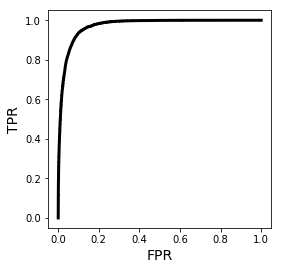

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


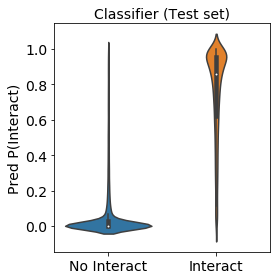

Average precision-recall score = 0.88


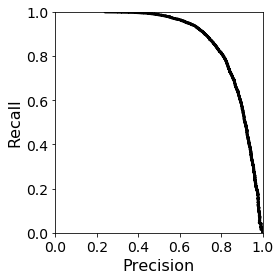

[[34675  1736]
 [ 1440  6629]]


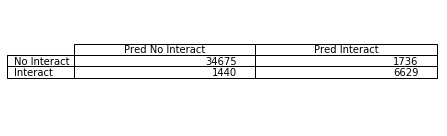

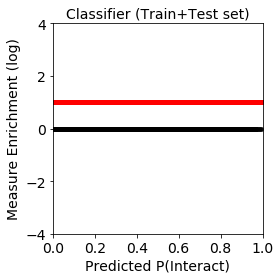

In [19]:
#Within-domain testing

experiment = "baker_big_set_5x_negatives"

design_dict = pickle.load(open('design_partition_' + experiment + '.pickle', 'rb'))
in_designs = design_dict['in_designs']
out_designs = design_dict['out_designs']

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

#pair_df['design_1'] = pair_df['monomer_id_1'].apply(lambda c: c[2:])
#pair_df['design_2'] = pair_df['monomer_id_2'].apply(lambda c: c[2:])

#pair_df = pair_df.loc[pair_df['design_1'].isin(out_designs)].copy().reset_index(drop=True)
#pair_df = pair_df.loc[pair_df['design_2'].isin(out_designs)].copy().reset_index(drop=True)

print("len(pair_df) = " + str(len(pair_df)))

#Generate training and test set indexes
valid_set_size = 0.05
test_set_size = 0.05

evaluate_on_data(model, pair_df, valid_set_size, test_set_size)


len(pair_df) = 26999
Training set size = 270
Validation set size = 270
Test set size = 26459
AUC = 0.972


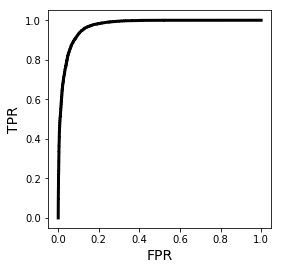

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


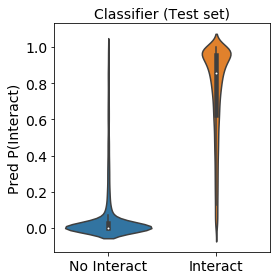

Average precision-recall score = 0.98


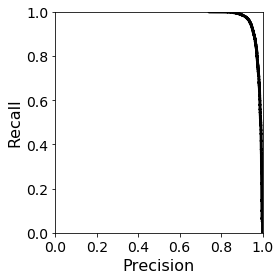

[[ 8383   424]
 [ 3110 14515]]


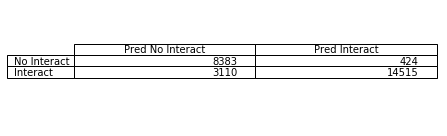

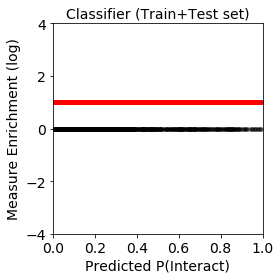

In [20]:
#Outside-domain testing

experiment = "baker_big_set_5x_negatives"

design_dict = pickle.load(open('design_partition_' + experiment + '.pickle', 'rb'))
in_designs = design_dict['in_designs']
out_designs = design_dict['out_designs']

pair_df = pd.read_csv("pair_df_" + experiment + "_out_shuffled.csv", sep="\t")

pair_df['design_1'] = pair_df['monomer_id_1'].apply(lambda c: c[:-1])
pair_df['design_2'] = pair_df['monomer_id_2'].apply(lambda c: c[:-1])

pair_df = pair_df.loc[pair_df['design_1'].isin(out_designs) & pair_df['design_2'].isin(out_designs)].copy().reset_index(drop=True)

print("len(pair_df) = " + str(len(pair_df)))

#Generate training and test set indexes
valid_set_size = 0.01
test_set_size = 0.98

evaluate_on_data(model, pair_df, valid_set_size, test_set_size)
